# Predicting Unemployment Trends

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import json
from dotenv import load_dotenv
import os
from prophet import Prophet
import plotly.express as px

## Import Data

### US States and Abbrevations - from file

In [2]:
# Import a dictionary of US States and abbrevations
us_states = np.load('Resources/us_states.npy', allow_pickle='TRUE').item()

### Unemployment data - from Federal Reserve Bank of St. Louis (FRED) - US

In [3]:
# Load environment variables and API key
load_dotenv()
fred_api_key = os.getenv("FRED_API_KEY") # calling environmental variables
# Series ID
series_id ='UNRATE'
# Query URL
query_url = 'https://api.stlouisfed.org/fred/series/observations?' +\
                f'series_id={series_id}&api_key={fred_api_key}&' +\
                'file_type=json&observation_start=1980-01-01'
# Get a reponse and convert it to json
response = requests.get(query_url).json()
# Create a temp dataframe to hold the values downloaded
unemployment_us_df = pd.DataFrame(response['observations'])\
                .drop(['realtime_start', 'realtime_end'], axis=1)\
                .set_index('date')\
                .rename(columns={'value': 'Unemplyoyment'}) 
# Change index name to Date
unemployment_us_df.index.names = ['Date']
# Check the head of the dataframe
unemployment_us_df.head()

Unemplyoyment
Date                    
1980-01-01           6.3
1980-02-01           6.3
1980-03-01           6.3
1980-04-01           6.9
1980-05-01           7.5

In [4]:
# Check data type of the index
unemployment_us_df.index.dtype

dtype('O')

In [5]:
# Convert index to datetime
unemployment_us_df.index = pd.to_datetime(unemployment_us_df.index)
# Check if data type of the index
unemployment_us_df.index.dtype

dtype('<M8[ns]')

In [6]:
# Change the data to type float
unemployment_us_df = unemployment_us_df.astype('float')
# Check if data types
unemployment_us_df.dtypes

Unemplyoyment    float64
dtype: object

In [7]:
# Check unemployment dataframe for any null values
sum(unemployment_us_df.isnull().sum())

0

In [8]:
# Visualiztion of the Unemployment Rate
fig = px.line(unemployment_us_df, 
        labels={'value': 'Unemployment Rate', 'Date': 'Year'}, 
        title='<b>Fed Unemployment Rate vs Year</b>')
# Remove legend and center title
fig.update_layout(showlegend=False, title_x=0.5)
# Change color of the line
fig.data[0].line.color = '#FF0000'
# Show Plot
fig.show()

In [9]:
fig.write_image('images/unemployment_us.png')

### Unemployment data - from Federal Reserve Bank of St. Louis (FRED) - US (State-wise)

In [10]:
# Create and empty dataframe to hold unemployment values of all states
unemployment_states_df = pd.DataFrame()

# Display message informing the user that the download can take a few seconds
print('This can take a few seconds as the program is downloading data for each state...')

# Loop through the states
for state in us_states.values():
    # Create series ID that needs to be downloaded
    series_id = state + 'URN'
    # Create the query url
    query_url = 'https://api.stlouisfed.org/fred/series/observations?' +\
                f'series_id={series_id}&api_key={fred_api_key}&' +\
                'file_type=json&observation_start=1980-01-01'
    # Use a try-except block to inform the user in case if data was not found for a state
    try:
        # Get a reponse and convert it to json
        response = requests.get(query_url).json()
        # Create a temp dataframe to hold the values downloaded
        temp_df = pd.DataFrame(response['observations'])\
            .drop(['realtime_start', 'realtime_end'], axis=1)\
            .set_index('date')\
            .rename(columns={'value': state}) 
        
        # Add the data to the unemployment_df
        # If employment_df is empty then assign the temp_df value to it
        if unemployment_states_df.empty:
            unemployment_states_df = temp_df
        # Else join unemployment_df with temp_df
        else:
            unemployment_states_df = unemployment_states_df.join(temp_df, how='outer')  
            
    # Print the exception        
    except:
        print('Data for {state} not found!')
        
# Display message informing the user that the download is complete
print('Download complete')

# Change index name to Date
unemployment_states_df.index.names = ['Date']
# Change index type to datetime
unemployment_states_df.index = pd.to_datetime(unemployment_states_df.index)

This can take a few seconds as the program is downloading data for each state...
Download complete


In [11]:
# View the unemployment dataframe
unemployment_states_df

AL    AK   AZ     AR     CA     CO     CT   DE     FL     GA  \
Date                                                                        
1980-01-01  8.1   9.6  6.2    7.3  6.800    5.1    5.8  7.8    6.0  5.600   
1980-02-01  8.2  10.4  5.5  7.300    6.8    5.0  5.700  7.3    5.3    5.8   
1980-03-01  7.6  10.1  5.8  6.600    6.6    5.0  5.200  6.9    5.1    5.7   
1980-04-01  7.7  10.8  5.7    6.9    6.6  5.300    5.3  7.3  5.300    5.9   
1980-05-01  8.1   9.7  6.6    7.4  6.500    6.0  5.600  6.9    5.6    6.3   
...         ...   ...  ...    ...    ...    ...    ...  ...    ...    ...   
2023-11-01  2.5   4.5  3.8    3.2    4.9    3.2    3.9  3.6    3.0    2.8   
2023-12-01  2.7   4.6  3.8    3.4    5.1    3.3    4.0  3.7    2.9    2.9   
2024-01-01  3.4   5.2  3.8    3.9    5.7    3.8    5.0  4.2    3.1    3.1   
2024-02-01  3.4   5.5  3.6    3.5    5.6    4.2    5.4  4.0    3.1    3.1   
2024-03-01  3.0   4.8  2.9    3.3    5.3    3.8    4.2  4.0    3.3    3.2   

            ...     SD   TN     TX     UT     VT   VA   WA    WV     WI     WY  
Date        ...                                                                 
1980-01-01  ...    4.7  6.8    5.2  5.800    6.0  5.2  8.4   9.3  6.000    4.1  
1980-02-01  ...    4.5  6.7    5.1    6.2    5.9  4.9  8.1   9.6    6.4    4.1  
1980-03-01  ...    4.7  6.3    5.0    6.1    5.7  4.7  7.4   9.7    6.6    4.2  
1980-04-01  ...    4.6  6.3    4.8    5.9    6.0  4.7  7.5  10.0    7.1    3.5  
1980-05-01  ...  4.800  6.7  5.100    5.7  6.000  5.2  7.7   9.8    7.8  3.500  
...         ...    ...  ...    ...    ...    ...  ...  ...   ...    ...    ...  
2023-11-01  ...    1.7  3.1    3.5    2.5    2.0  2.9  4.3   3.7    2.7    2.7  
2023-12-01  ...    2.0  3.0    3.5    2.5    2.2  2.7  4.6   3.9    2.9    2.6  
2024-01-01  ...    2.2  3.5    4.1    3.0    2.7  2.7  5.4   4.8    2.8    3.7  
2024-02-01  ...    2.7  2.8    4.4    3.3    2.6  2.9  5.6   5.0    3.3    3.6  
2024-03-01  ...    2.0  3.0    4.1    2.8    2.1  2.4  5.1   4.9    3.5    3.3  

[531 rows x 50 columns]

In [12]:
# Check data type of the index
unemployment_states_df.index.dtype

dtype('<M8[ns]')

In [13]:
# Convert the data in the columns to float
unemployment_states_df = unemployment_states_df.astype('float')

In [14]:
# Display tail of unemployment dataframe
unemployment_states_df.tail()

AL   AK   AZ   AR   CA   CO   CT   DE   FL   GA  ...   SD   TN  \
Date                                                          ...             
2023-11-01  2.5  4.5  3.8  3.2  4.9  3.2  3.9  3.6  3.0  2.8  ...  1.7  3.1   
2023-12-01  2.7  4.6  3.8  3.4  5.1  3.3  4.0  3.7  2.9  2.9  ...  2.0  3.0   
2024-01-01  3.4  5.2  3.8  3.9  5.7  3.8  5.0  4.2  3.1  3.1  ...  2.2  3.5   
2024-02-01  3.4  5.5  3.6  3.5  5.6  4.2  5.4  4.0  3.1  3.1  ...  2.7  2.8   
2024-03-01  3.0  4.8  2.9  3.3  5.3  3.8  4.2  4.0  3.3  3.2  ...  2.0  3.0   

             TX   UT   VT   VA   WA   WV   WI   WY  
Date                                                
2023-11-01  3.5  2.5  2.0  2.9  4.3  3.7  2.7  2.7  
2023-12-01  3.5  2.5  2.2  2.7  4.6  3.9  2.9  2.6  
2024-01-01  4.1  3.0  2.7  2.7  5.4  4.8  2.8  3.7  
2024-02-01  4.4  3.3  2.6  2.9  5.6  5.0  3.3  3.6  
2024-03-01  4.1  2.8  2.1  2.4  5.1  4.9  3.5  3.3  

[5 rows x 50 columns]

In [15]:
# Check unemployment dataframe for any null values
sum(unemployment_states_df.isnull().sum())

0

### PCE Inflation rate

In [16]:
# Series ID
series_id ='PCETRIM6M680SFRBDAL'
# Query URL
query_url = 'https://api.stlouisfed.org/fred/series/observations?' +\
                f'series_id={series_id}&api_key={fred_api_key}&' +\
                'file_type=json&observation_start=1980-01-01'

In [17]:
# Get a reponse and convert it to json
response = requests.get(query_url).json()
# Create a temp dataframe to hold the values downloaded
inflation_df = pd.DataFrame(response['observations'])\
                .drop(['realtime_start', 'realtime_end'], axis=1)\
                .set_index('date')\
                .rename(columns={'value': 'PCE Inflation'}) 
# Change index name to Date
inflation_df.index.names = ['Date']
# Check the head of the dataframe
inflation_df.tail()

PCE Inflation
Date                    
2023-11-01          2.59
2023-12-01          2.48
2024-01-01           3.0
2024-02-01          3.15
2024-03-01          3.02

In [18]:
# Convert index to datetime
inflation_df.index = pd.to_datetime(inflation_df.index)
# Check if data type of the index
inflation_df.index.dtype

dtype('<M8[ns]')

In [19]:
# Change the data to type float
inflation_df = inflation_df.astype('float')

In [20]:
# Check the head of the dataframe
inflation_df.head()

PCE Inflation
Date                     
1980-01-01           8.81
1980-02-01           9.00
1980-03-01           9.17
1980-04-01           8.59
1980-05-01           8.81

In [21]:
# Check for any null values
sum(inflation_df.isnull().sum())

0

In [22]:
unemployment_us_df.merge(inflation_df, on='Date')

Unemplyoyment  PCE Inflation
Date                                    
1980-01-01            6.3           8.81
1980-02-01            6.3           9.00
1980-03-01            6.3           9.17
1980-04-01            6.9           8.59
1980-05-01            7.5           8.81
...                   ...            ...
2023-11-01            3.7           2.59
2023-12-01            3.7           2.48
2024-01-01            3.7           3.00
2024-02-01            3.9           3.15
2024-03-01            3.8           3.02

[531 rows x 2 columns]

In [23]:
# Visualiztion of the PCE Inflation rate
fig = px.line(inflation_df.merge(unemployment_us_df, on='Date'), 
        labels={'value': 'Rate', 'Date': 'Year', 'variable':''}, 
        title='<b>PCE Inflation Rate and Unemployment</b>')
fig.update_layout( title_x=0.5)
fig.show()

In [24]:
fig.write_image('images/inflation.png')

#### Fed Funds Rate

In [25]:
series_id = 'FEDFUNDS'
fedfunds_url = 'https://api.stlouisfed.org/fred/series/observations?' +\
                f'series_id={series_id}&api_key={fred_api_key}&' +\
                'file_type=json&observation_start=1980-01-01'
response = requests.get(fedfunds_url).json()

In [26]:
fedfunds_df = pd.DataFrame(response['observations'])\
                        .drop(['realtime_start', 'realtime_end'], axis=1)\
                        .set_index('date')\
                        .rename(columns={'value': 'Fed Funds'}) 
fedfunds_df.index.names=['Date']

fedfunds_df.head()

Fed Funds
Date                
1980-01-01     13.82
1980-02-01     14.13
1980-03-01     17.19
1980-04-01     17.61
1980-05-01     10.98

In [27]:
# Convert index to datetime
fedfunds_df.index = pd.to_datetime(fedfunds_df.index)
# Check if data type of the index
fedfunds_df.index.dtype

dtype('<M8[ns]')

In [28]:
# Change the data to type float
fedfunds_df = fedfunds_df.astype('float')

In [29]:
# Check if there are any null values
sum(fedfunds_df.isnull().sum())

0

In [30]:
# Visualiztion of the Fed Funds Rate
fig = px.line(fedfunds_df.merge(unemployment_us_df, on='Date'), 
        labels={'value': 'Fed Funds rate', 'Date': 'Year', 'variable':''}, 
        title='<b>Fed Funds Rate and Unemployment</b>')
fig.update_layout(title_x=0.5)
fig.data[0].line.color = '#008000'
fig.show()

In [31]:
fig.write_image('images/fed_funds_rate.png')

### Get the target states on which the analysis needs to be carried out

#### Filter the data for the states with the highest average unemployment over the last 10 years

In [32]:
years = 10
unemployment_10y_df = unemployment_states_df.iloc[(years*-12):,:]
unemployment_10y_df

AL   AK   AZ   AR   CA   CO   CT   DE   FL   GA  ...   SD   TN  \
Date                                                          ...             
2014-04-01  6.2  6.8  6.2  5.4  7.3  5.5  6.3  5.4  6.1  6.8  ...  3.4  6.0   
2014-05-01  6.5  6.7  6.7  5.8  7.3  5.0  6.7  5.5  6.4  7.2  ...  3.2  6.3   
2014-06-01  7.2  6.9  7.1  6.0  7.6  5.0  6.7  5.9  6.6  7.6  ...  3.2  7.1   
2014-07-01  7.3  6.4  7.4  6.4  8.0  4.9  7.0  6.0  6.9  7.8  ...  3.1  7.3   
2014-08-01  7.0  6.1  7.3  5.9  7.7  4.6  6.8  5.9  6.8  7.5  ...  3.2  6.9   
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2023-11-01  2.5  4.5  3.8  3.2  4.9  3.2  3.9  3.6  3.0  2.8  ...  1.7  3.1   
2023-12-01  2.7  4.6  3.8  3.4  5.1  3.3  4.0  3.7  2.9  2.9  ...  2.0  3.0   
2024-01-01  3.4  5.2  3.8  3.9  5.7  3.8  5.0  4.2  3.1  3.1  ...  2.2  3.5   
2024-02-01  3.4  5.5  3.6  3.5  5.6  4.2  5.4  4.0  3.1  3.1  ...  2.7  2.8   
2024-03-01  3.0  4.8  2.9  3.3  5.3  3.8  4.2  4.0  3.3  3.2  ...  2.0  3.0   

             TX   UT   VT   VA   WA   WV   WI   WY  
Date                                                
2014-04-01  4.8  3.3  4.1  4.7  5.5  6.3  5.5  4.3  
2014-05-01  5.1  3.4  3.8  5.2  5.8  6.3  5.3  4.3  
2014-06-01  5.5  3.9  4.0  5.2  5.6  6.4  5.6  4.3  
2014-07-01  5.7  3.8  4.1  5.3  5.8  6.6  5.4  4.2  
2014-08-01  5.4  3.9  4.0  5.4  5.8  6.6  5.1  4.1  
...         ...  ...  ...  ...  ...  ...  ...  ...  
2023-11-01  3.5  2.5  2.0  2.9  4.3  3.7  2.7  2.7  
2023-12-01  3.5  2.5  2.2  2.7  4.6  3.9  2.9  2.6  
2024-01-01  4.1  3.0  2.7  2.7  5.4  4.8  2.8  3.7  
2024-02-01  4.4  3.3  2.6  2.9  5.6  5.0  3.3  3.6  
2024-03-01  4.1  2.8  2.1  2.4  5.1  4.9  3.5  3.3  

[120 rows x 50 columns]

In [33]:
# Geographically where are the unemployment is the highest and lowest over the past 10 years
fig = px.choropleth(unemployment_10y_df, 
                    locations=unemployment_10y_df.columns.tolist(), 
                    locationmode="USA-states", 
                    scope="usa", 
                    color=unemployment_10y_df.mean().tolist(), 
                    color_continuous_scale='reds', 
                    title='<b>Unemployment in the US (10-year average)</b>',
                    labels={'color':'Rate'})
fig.update_layout(title_x=0.5)
fig.show()

In [34]:
fig.write_image('images/unemployment_states.png')

In [35]:
# Get the mean of each column, sort the values and get the bottom five values
highest_unemployment = unemployment_10y_df\
                            .mean()\
                            .sort_values()\
                            .tail()
highest_unemployment

IL    5.596667
NM    5.789167
CA    5.838333
AK    6.035833
NV    6.425833
dtype: float64

In [36]:
# Plot the states with the highest unemployment
fig = px.bar(highest_unemployment, 
             labels={'value': 'Unemployment Rate', 'index': 'State', 'color': 'Rate'},
             color=highest_unemployment,
             color_continuous_scale = 'pinkyl',
             title='<b>Highest Unemployment States</b>'
            )
fig.update_layout(showlegend=False, yaxis_range=[5,6.5], title_x=0.5)
fig.show()

In [37]:
fig.write_image('images/highest_unemployment.png')

#### Filter the data for the states with the lowest average unemployment over the last 10 years

In [38]:
# Get the mean of each column, sort the values, get the bottom five values, get the index and convert it to a list
lowest_unemployment = unemployment_10y_df\
                            .mean()\
                            .sort_values()\
                            .head()\
# View the dataseries
lowest_unemployment

ND    2.737500
SD    2.839167
NE    2.927500
VT    3.125833
UT    3.150000
dtype: float64

In [39]:
# Plot the states with the lowest employment
fig = px.bar(lowest_unemployment, 
             labels={'value': 'Unemployment Rate', 'index': 'State', 'color': 'Rate'},
             color=lowest_unemployment,
             color_continuous_scale = 'algae',
             title='<b>Lowest Unemployment States</b>'
            )
fig.update_layout(showlegend=False, yaxis_range=[2.5,3.5], title_x=0.5)
fig.show()

In [40]:
fig.write_image('images/lowest_unemployment.png')

### Explore Relationships and Visualizations

#### Unemployment and PCE Inflation Rate

In [41]:
# Correlation for the states with the highest unemployment
corr_unemp_inflation = []
for state in highest_unemployment.index:
    state_df = unemployment_states_df.loc[:,state]
    corr_unemp_inflation.append(pd.merge(state_df,inflation_df, on='Date', how='inner').corr().iloc[0,1])
    
corr_high_unemp_inflation_df = pd.DataFrame(
    {'State': highest_unemployment.index,
     'Correlation': corr_unemp_inflation
    })
corr_high_unemp_inflation_df

State  Correlation
0    IL     0.169862
1    NM     0.182617
2    CA    -0.142199
3    AK     0.317510
4    NV    -0.111754

In [42]:
# Correlation for the states with the lowest unemployment
corr_unemp_inflation = []
for state in lowest_unemployment.index:
    state_df = unemployment_states_df.loc[:,state]
    corr_unemp_inflation.append(pd.merge(state_df,inflation_df, on='Date', how='inner').corr().iloc[0,1])
    
corr_low_unemp_inflation_df = pd.DataFrame(
    {'State': lowest_unemployment.index,
     'Correlation': corr_unemp_inflation
    })
corr_low_unemp_inflation_df

State  Correlation
0    ND     0.396038
1    SD     0.296343
2    NE     0.140649
3    VT     0.198921
4    UT     0.270922

In [43]:
# Create a list of lagged periods
lagged_period = [6, 12, 18, 24, 30, 36]

In [44]:
# Create a list of lagged dataframes using the lagged periods
lagged_unemployment_dfs = [unemployment_states_df.shift(period).dropna() for period in lagged_period]
# View the first lagged unemployment dataframe in the list
lagged_unemployment_dfs[0]

AL    AK   AZ   AR   CA   CO   CT   DE   FL   GA  ...   SD   TN  \
Date                                                           ...             
1980-07-01  8.1   9.6  6.2  7.3  6.8  5.1  5.8  7.8  6.0  5.6  ...  4.7  6.8   
1980-08-01  8.2  10.4  5.5  7.3  6.8  5.0  5.7  7.3  5.3  5.8  ...  4.5  6.7   
1980-09-01  7.6  10.1  5.8  6.6  6.6  5.0  5.2  6.9  5.1  5.7  ...  4.7  6.3   
1980-10-01  7.7  10.8  5.7  6.9  6.6  5.3  5.3  7.3  5.3  5.9  ...  4.6  6.3   
1980-11-01  8.1   9.7  6.6  7.4  6.5  6.0  5.6  6.9  5.6  6.3  ...  4.8  6.7   
...         ...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2023-11-01  2.1   4.0  3.8  2.9  4.3  3.0  3.4  3.7  2.7  3.3  ...  2.0  3.1   
2023-12-01  2.8   4.4  4.2  3.5  4.7  3.5  3.7  4.2  3.1  3.5  ...  2.1  3.7   
2024-01-01  2.6   3.8  4.3  3.7  4.8  3.3  3.8  4.1  3.1  3.2  ...  1.7  3.5   
2024-02-01  2.8   3.8  4.5  3.6  5.2  3.4  3.9  4.4  3.3  3.6  ...  2.1  3.4   
2024-03-01  2.6   4.0  4.2  3.5  4.9  3.1  3.7  3.9  3.1  3.1  ...  1.8  3.3   

             TX   UT   VT   VA   WA    WV   WI   WY  
Date                                                 
1980-07-01  5.2  5.8  6.0  5.2  8.4   9.3  6.0  4.1  
1980-08-01  5.1  6.2  5.9  4.9  8.1   9.6  6.4  4.1  
1980-09-01  5.0  6.1  5.7  4.7  7.4   9.7  6.6  4.2  
1980-10-01  4.8  5.9  6.0  4.7  7.5  10.0  7.1  3.5  
1980-11-01  5.1  5.7  6.0  5.2  7.7   9.8  7.8  3.5  
...         ...  ...  ...  ...  ...   ...  ...  ...  
2023-11-01  3.9  2.6  1.6  2.8  3.6   3.6  2.8  2.7  
2023-12-01  4.2  2.8  2.0  2.9  3.7   4.1  3.5  2.8  
2024-01-01  4.2  2.7  1.8  2.9  3.8   4.0  3.2  2.5  
2024-02-01  4.2  2.9  2.0  3.2  4.3   4.4  3.4  2.5  
2024-03-01  3.9  2.5  2.0  3.0  4.0   3.7  2.9  2.3  

[525 rows x 50 columns]

In [45]:
# Lagged trend for the states with the highest unemployment

# Counter to count through the lagged period list
count = 0
# Loop through the dataframes
for df in lagged_unemployment_dfs:
    # Create an empty list to hold the correlation values
    lagged_corr = []
    # Loop through the list of highest unemployment states
    for state in highest_unemployment.index:
        # Filter the data for the required state
        state_df = df.loc[:,state]
        # Add the correlation value of every state to the list
        lagged_corr.append(pd.merge(state_df,inflation_df, on='Date', how='inner').corr().iloc[0,1])
        
    # Add column to the correlation dataframe
    column_name = f'Lagged {lagged_period[count]} Months'
    corr_high_unemp_inflation_df[column_name] = pd.DataFrame(lagged_corr)
    
    # Increase count by 1
    count += 1
# Save as csv
corr_high_unemp_inflation_df.to_csv('Tables/corr_high_unemp_inflation_df.csv')
# Display the dataframe
corr_high_unemp_inflation_df

State  Correlation  Lagged 6 Months  Lagged 12 Months  Lagged 18 Months  \
0    IL     0.169862         0.142479          0.170357          0.256839   
1    NM     0.182617         0.217136          0.318316          0.443257   
2    CA    -0.142199        -0.166045         -0.125186         -0.041590   
3    AK     0.317510         0.319977          0.387615          0.472766   
4    NV    -0.111754        -0.132773         -0.093309          0.013388   

   Lagged 24 Months  Lagged 30 Months  Lagged 36 Months  
0          0.301196          0.279078          0.215066  
1          0.523164          0.483480          0.408882  
2         -0.008506         -0.037975         -0.124794  
3          0.540515          0.519122          0.467058  
4          0.070652          0.066086         -0.018116

In [46]:
# Mean of all lagged periods shows that the correlation is the strongest at 24 months
corr_high_unemp_inflation_df[['Correlation', 'Lagged 6 Months', 'Lagged 12 Months',
       'Lagged 18 Months', 'Lagged 24 Months', 'Lagged 30 Months',
       'Lagged 36 Months']].mean()

Correlation         0.083207
Lagged 6 Months     0.076155
Lagged 12 Months    0.131559
Lagged 18 Months    0.228932
Lagged 24 Months    0.285404
Lagged 30 Months    0.261958
Lagged 36 Months    0.189619
dtype: float64

In [47]:
# Lagged trend for the states with the lowest unemployment

# Counter to count through the lagged period list
count = 0
# Loop through the dataframes
for df in lagged_unemployment_dfs:
    # Create an empty list to hold the correlation values
    lagged_corr = []
    # Loop through the list of highest unemployment states
    for state in lowest_unemployment.index:
        # Filter the data for the required state
        state_df = df.loc[:,state]
        # Add the correlation value of every state to the list
        lagged_corr.append(pd.merge(state_df,inflation_df, on='Date', how='inner').corr().iloc[0,1])
    
    # Add column to the correlation dataframe
    column_name = f'Lagged {lagged_period[count]} Months'
    corr_low_unemp_inflation_df[column_name] = pd.DataFrame(lagged_corr)
    # Increase count by 1
    count += 1
# Save as csv
corr_low_unemp_inflation_df.to_csv('Tables/corr_low_unemp_inflation.csv') 
# Display the dataframe
corr_low_unemp_inflation_df

State  Correlation  Lagged 6 Months  Lagged 12 Months  Lagged 18 Months  \
0    ND     0.396038         0.385978          0.450929          0.540048   
1    SD     0.296343         0.267433          0.293300          0.367315   
2    NE     0.140649         0.113049          0.152373          0.250585   
3    VT     0.198921         0.154671          0.164106          0.202576   
4    UT     0.270922         0.241181          0.264121          0.330126   

   Lagged 24 Months  Lagged 30 Months  Lagged 36 Months  
0          0.590893          0.543600          0.466905  
1          0.422722          0.421840          0.369660  
2          0.358985          0.395306          0.396305  
3          0.210711          0.152319          0.074260  
4          0.386400          0.377654          0.335994

In [48]:
# Mean of all lagged periods shows that the correlation is the strongest at 24 months
corr_low_unemp_inflation_df[['Correlation', 'Lagged 6 Months', 'Lagged 12 Months',
       'Lagged 18 Months', 'Lagged 24 Months', 'Lagged 30 Months',
       'Lagged 36 Months']].mean()

Correlation         0.260574
Lagged 6 Months     0.232462
Lagged 12 Months    0.264966
Lagged 18 Months    0.338130
Lagged 24 Months    0.393942
Lagged 30 Months    0.378144
Lagged 36 Months    0.328625
dtype: float64

#### Unemployment and Fed Funds Rate

In [49]:
# Correlation for the states with the highest unemployment
corr_unemp_fedfunds = []
for state in highest_unemployment.index:
    state_df = unemployment_states_df.loc[:,state]
    corr_unemp_fedfunds.append(pd.merge(state_df,fedfunds_df, on='Date', how='inner').corr().iloc[0,1])
# Create a dataframe      
corr_high_unemp_fedfunds_df = pd.DataFrame(
    {'State': highest_unemployment.index,
     'Correlation': corr_unemp_fedfunds
    })
# Check the dataframe
corr_high_unemp_fedfunds_df

State  Correlation
0    IL     0.141123
1    NM     0.278848
2    CA    -0.144722
3    AK     0.431423
4    NV    -0.200720

In [50]:
# Correlation for the states with the lowest unemployment
corr_unemp_fedfunds = []
for state in lowest_unemployment.index:
    state_df = unemployment_states_df.loc[:,state]
    corr_unemp_fedfunds.append(pd.merge(state_df,fedfunds_df, on='Date', how='inner').corr().iloc[0,1])
# Create a dataframe    
corr_low_unemp_fedfunds_df = pd.DataFrame(
    {'State': lowest_unemployment.index,
     'Correlation': corr_unemp_fedfunds
    })
# Check the dataframe
corr_low_unemp_fedfunds_df

State  Correlation
0    ND     0.496182
1    SD     0.344919
2    NE     0.174563
3    VT     0.221536
4    UT     0.321065

In [51]:
# Lagged trend for the states with the highest unemployment

# Counter to count through the lagged period list
count = 0
# Loop through the dataframes
for df in lagged_unemployment_dfs:
    # Create an empty list to hold the correlation values
    lagged_corr = []
    # Loop through the list of highest unemployment states
    for state in highest_unemployment.index:
        # Filter the data for the required state
        state_df = df.loc[:,state]
        # Add the correlation value of every state to the list
        lagged_corr.append(pd.merge(state_df,fedfunds_df, on='Date', how='inner').corr().iloc[0,1])
    
    # Add column to the correlation dataframe
    column_name = f'Lagged {lagged_period[count]} Months'
    corr_high_unemp_fedfunds_df[column_name] = pd.DataFrame(lagged_corr)
    # Increase count by 1
    count += 1
# Save as csv
corr_high_unemp_fedfunds_df.to_csv('Tables/corr_high_unemp_fedfunds_df.csv') 
# Display the dataframe
corr_high_unemp_fedfunds_df

State  Correlation  Lagged 6 Months  Lagged 12 Months  Lagged 18 Months  \
0    IL     0.141123         0.125918          0.126238          0.154807   
1    NM     0.278848         0.295246          0.350752          0.433590   
2    CA    -0.144722        -0.167435         -0.159875         -0.118262   
3    AK     0.431423         0.432879          0.439727          0.504798   
4    NV    -0.200720        -0.217424         -0.220424         -0.203312   

   Lagged 24 Months  Lagged 30 Months  Lagged 36 Months  
0          0.196729          0.262776          0.289435  
1          0.531266          0.599068          0.606494  
2         -0.052784          0.028180          0.058407  
3          0.561975          0.641395          0.645080  
4         -0.163897         -0.088637         -0.050491

In [52]:
# Mean of all lagged periods shows that the correlation is the strongest at 36 months
corr_high_unemp_fedfunds_df[['Correlation', 'Lagged 6 Months', 'Lagged 12 Months',
       'Lagged 18 Months', 'Lagged 24 Months', 'Lagged 30 Months',
       'Lagged 36 Months']].mean()

Correlation         0.101190
Lagged 6 Months     0.093837
Lagged 12 Months    0.107284
Lagged 18 Months    0.154324
Lagged 24 Months    0.214658
Lagged 30 Months    0.288556
Lagged 36 Months    0.309785
dtype: float64

In [53]:
# Lagged trend for the states with the lowest unemployment

# Counter to count through the lagged period list
count = 0
# Loop through the dataframes
for df in lagged_unemployment_dfs:
    # Create an empty list to hold the correlation values
    lagged_corr = []
    # Loop through the list of highest unemployment states
    for state in lowest_unemployment.index:
        # Filter the data for the required state
        state_df = df.loc[:,state]
        # Add the correlation value of every state to the list
        lagged_corr.append(pd.merge(state_df,fedfunds_df, on='Date', how='inner').corr().iloc[0,1])
    
    # Add column to the correlation dataframe
    column_name = f'Lagged {lagged_period[count]} Months'
    corr_low_unemp_fedfunds_df[column_name] = pd.DataFrame(lagged_corr)
    # Increase count by 1
    count += 1
# Save as csv
corr_low_unemp_fedfunds_df.to_csv('Tables/corr_low_unemp_fedfunds_df.csv')
# Display the dataframe
corr_low_unemp_fedfunds_df

State  Correlation  Lagged 6 Months  Lagged 12 Months  Lagged 18 Months  \
0    ND     0.496182         0.497873          0.499332          0.537934   
1    SD     0.344919         0.347072          0.342120          0.370169   
2    NE     0.174563         0.163145          0.159541          0.189788   
3    VT     0.221536         0.193898          0.173511          0.186581   
4    UT     0.321065         0.313290          0.317538          0.339595   

   Lagged 24 Months  Lagged 30 Months  Lagged 36 Months  
0          0.566258          0.633861          0.631088  
1          0.378367          0.426192          0.423767  
2          0.219910          0.276738          0.293542  
3          0.214599          0.283804          0.306824  
4          0.365842          0.410097          0.418160

In [54]:
# Mean of all lagged periods shows that the correlation is the strongest at 36 months
corr_low_unemp_fedfunds_df[['Correlation', 'Lagged 6 Months', 'Lagged 12 Months',
       'Lagged 18 Months', 'Lagged 24 Months', 'Lagged 30 Months',
       'Lagged 36 Months']].mean()

Correlation         0.311653
Lagged 6 Months     0.303056
Lagged 12 Months    0.298408
Lagged 18 Months    0.324813
Lagged 24 Months    0.348995
Lagged 30 Months    0.406138
Lagged 36 Months    0.414676
dtype: float64

#### Forecast unemployment rate for states

In [55]:
# Function to create forecast based on the dataframe and duration
def predict(df, duration):
    # Reset index
    df.reset_index(inplace=True)
    # Change column names
    df.columns = ['ds', 'y']
    # Create a prophet object
    m = Prophet()
    # Fit 
    m.fit(df)
    # Extend the dataframe basded on the duration
    future = m.make_future_dataframe(periods=duration, freq='M')
    # Create a forecast
    forecast = m.predict(future)
    # Return the prohet object and associated forecast
    return m,forecast

In [56]:
# Function to create a plot for the forecast
def forecast_plot(m, forecast, state):
    # Plot the forecast
    fig = m.plot(forecast)
    # Create a filename
    filename = f'images/forecast_{state}.png'
    # Add title to figure
    ax = fig.gca()
    state_name = list(us_states.keys())[list(us_states.values()).index(state)]
    ax.set_title(state_name, size=15)
    # Save figure to filename
    fig.savefig(filename, bbox_inches='tight')

13:49:59 - cmdstanpy - INFO - Chain [1] start processing
13:49:59 - cmdstanpy - INFO - Chain [1] done processing
13:49:59 - cmdstanpy - INFO - Chain [1] start processing
13:49:59 - cmdstanpy - INFO - Chain [1] done processing
13:49:59 - cmdstanpy - INFO - Chain [1] start processing
13:49:59 - cmdstanpy - INFO - Chain [1] done processing
13:50:00 - cmdstanpy - INFO - Chain [1] start processing
13:50:00 - cmdstanpy - INFO - Chain [1] done processing
13:50:00 - cmdstanpy - INFO - Chain [1] start processing
13:50:00 - cmdstanpy - INFO - Chain [1] done processing


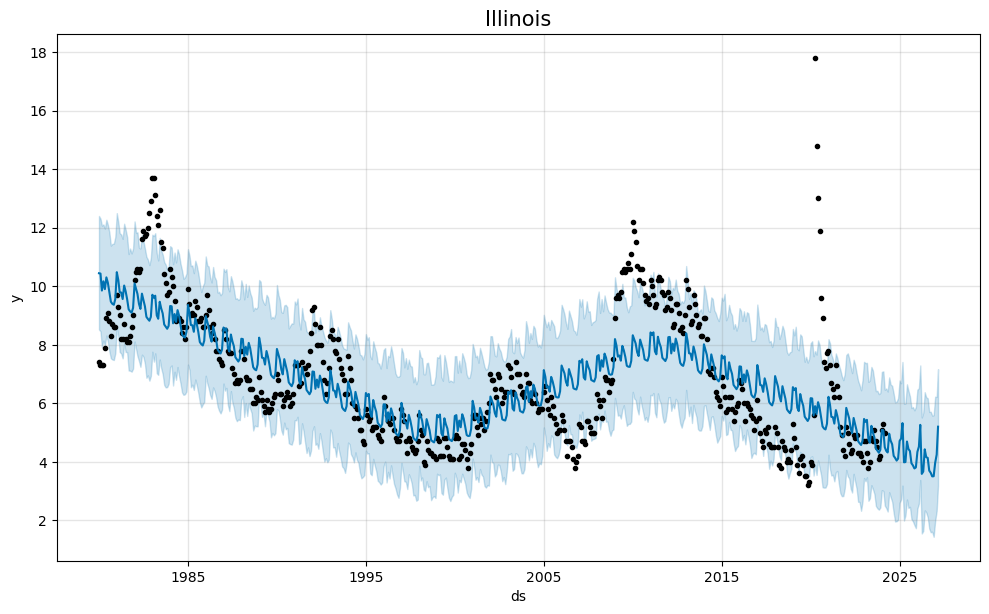

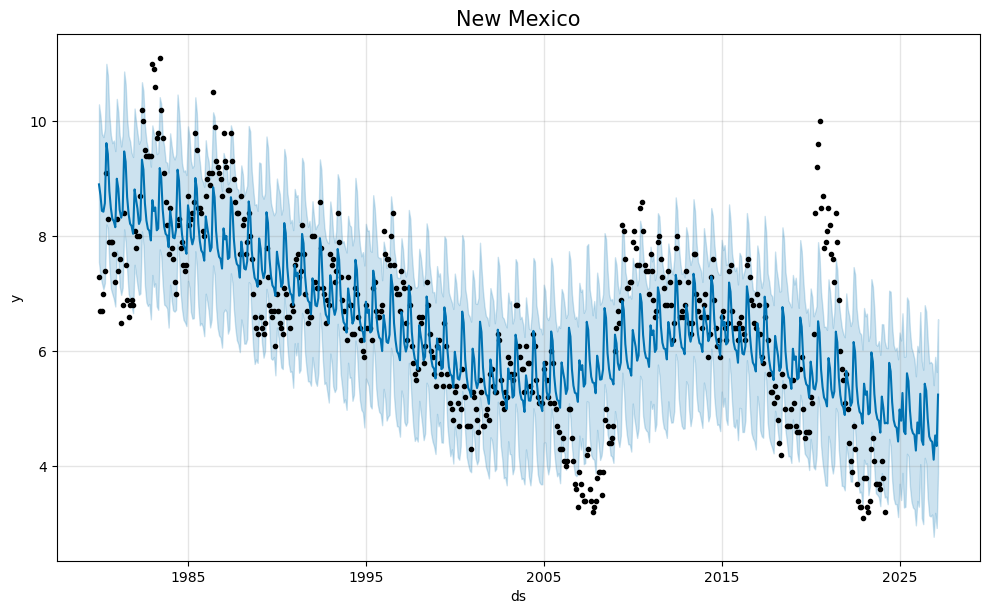

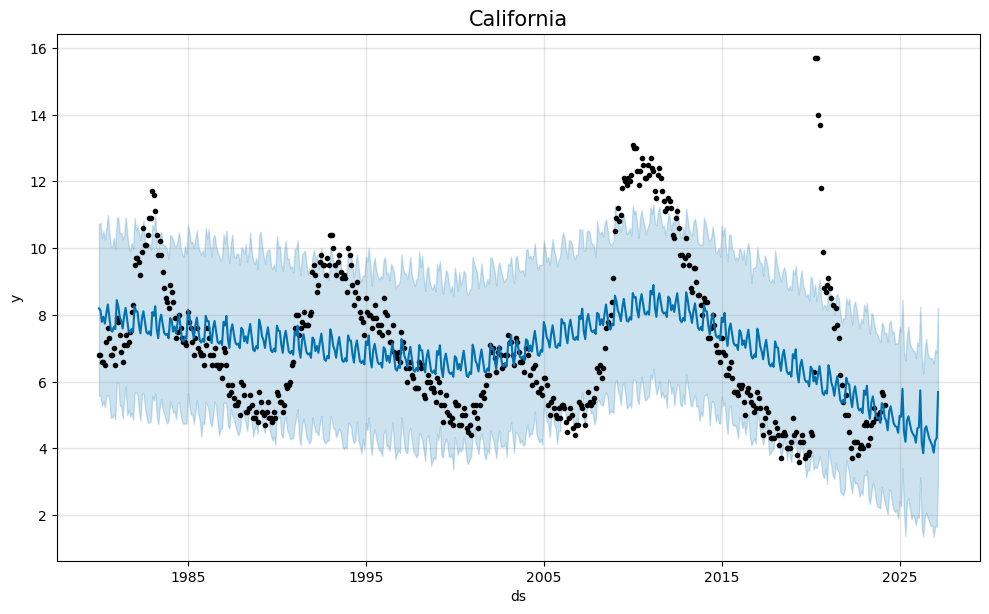

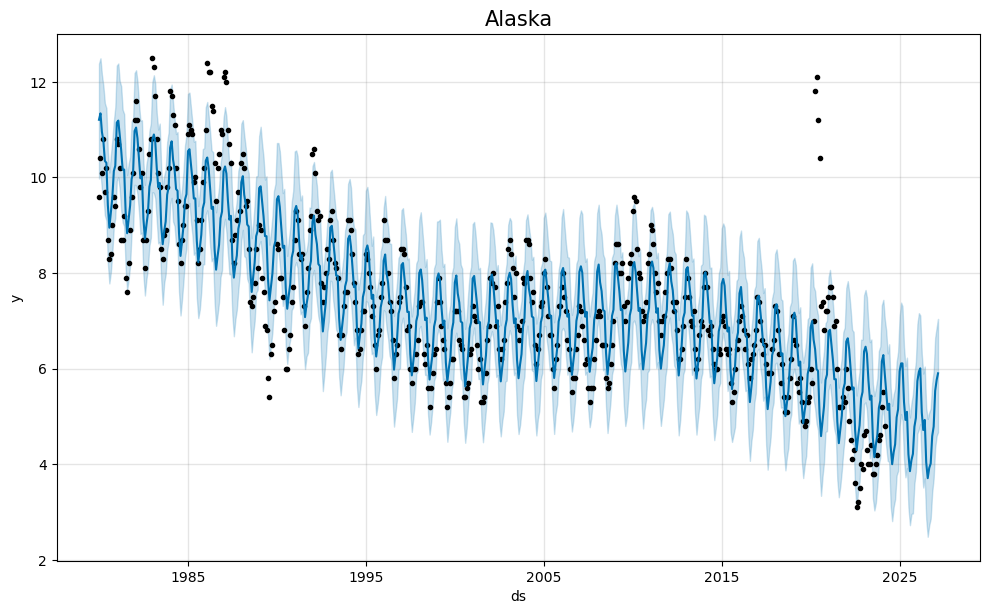

In [57]:
# Forecast unemployment for the states with the highest unemployment
period = 36 # months
# Loop through the states
for state in highest_unemployment.index:
    m, forecast = predict(pd.DataFrame(unemployment_states_df.loc[:,state]), period)
    forecast_plot(m, forecast, state)

13:50:01 - cmdstanpy - INFO - Chain [1] start processing
13:50:01 - cmdstanpy - INFO - Chain [1] done processing
13:50:01 - cmdstanpy - INFO - Chain [1] start processing
13:50:01 - cmdstanpy - INFO - Chain [1] done processing
13:50:01 - cmdstanpy - INFO - Chain [1] start processing
13:50:01 - cmdstanpy - INFO - Chain [1] done processing
13:50:02 - cmdstanpy - INFO - Chain [1] start processing
13:50:02 - cmdstanpy - INFO - Chain [1] done processing
13:50:02 - cmdstanpy - INFO - Chain [1] start processing
13:50:02 - cmdstanpy - INFO - Chain [1] done processing


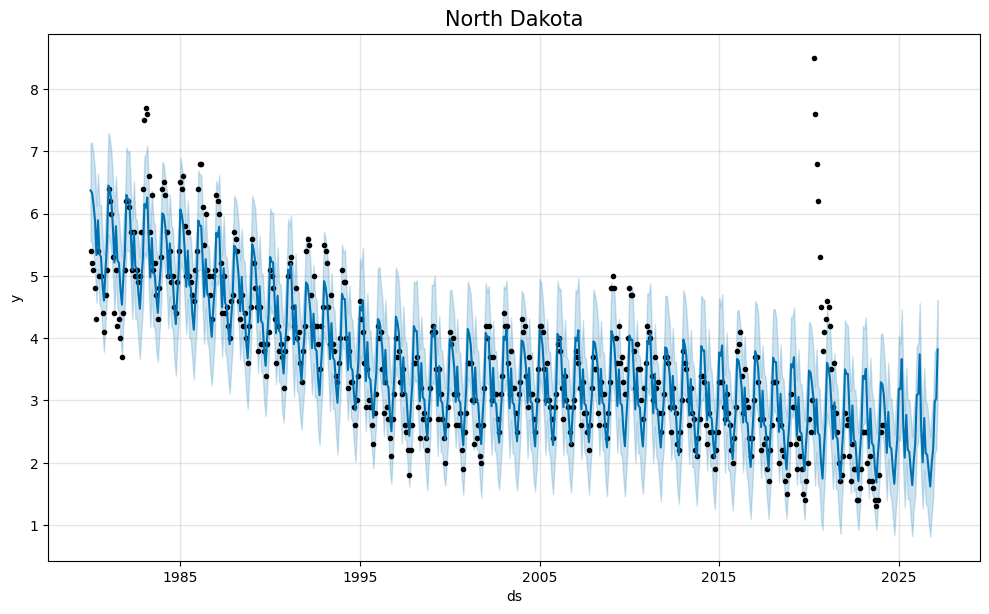

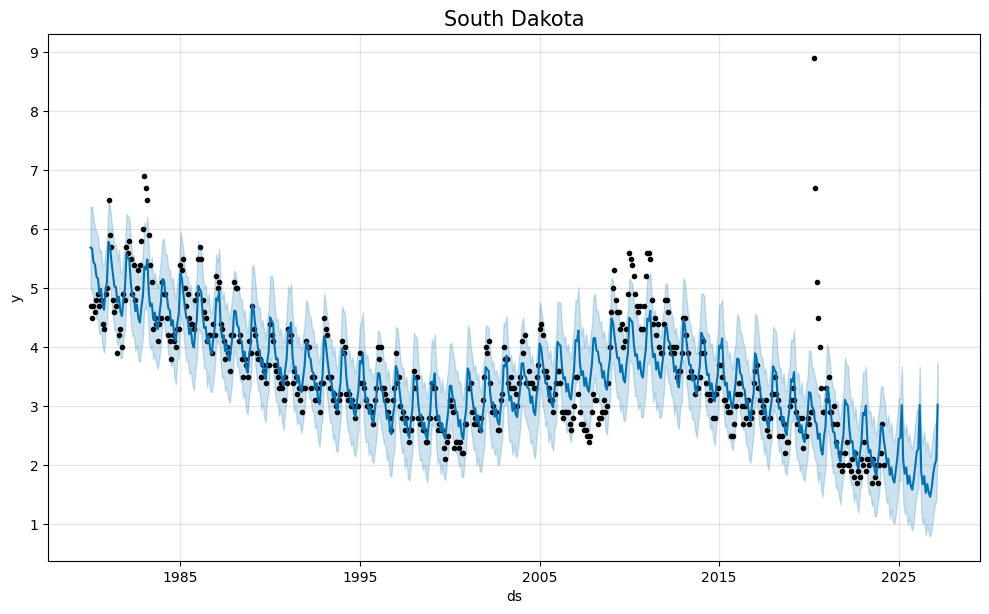

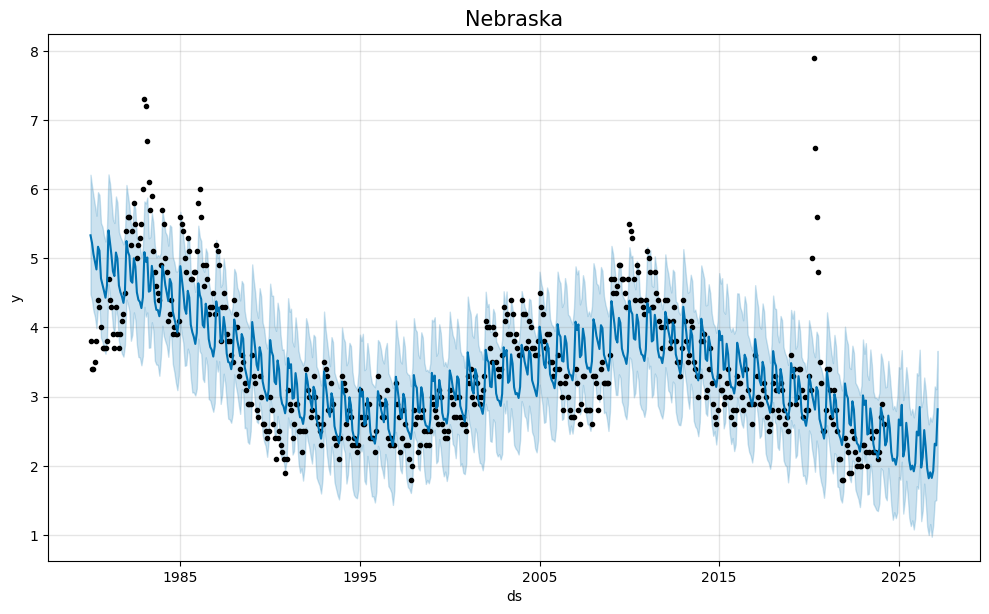

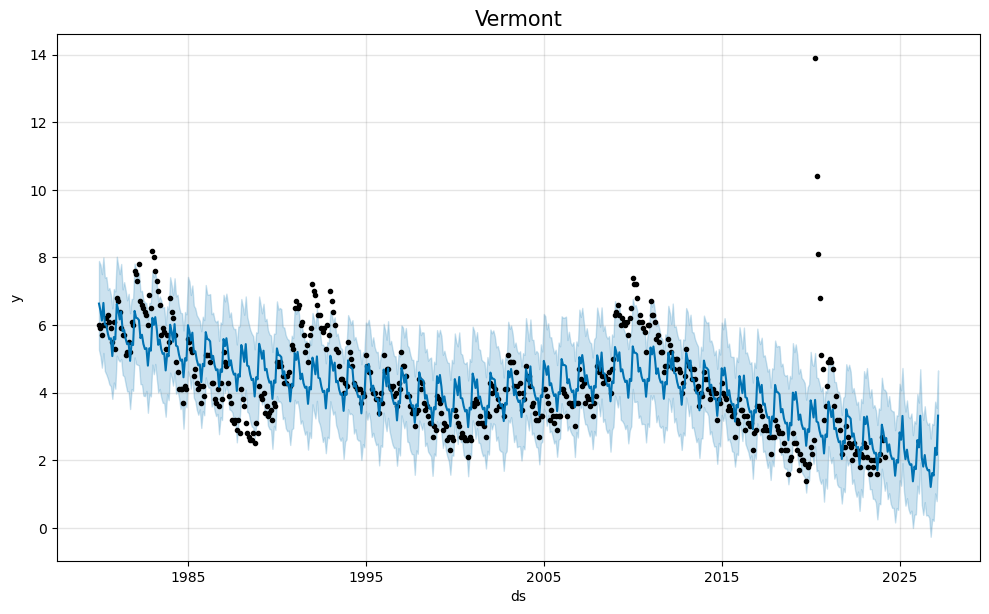

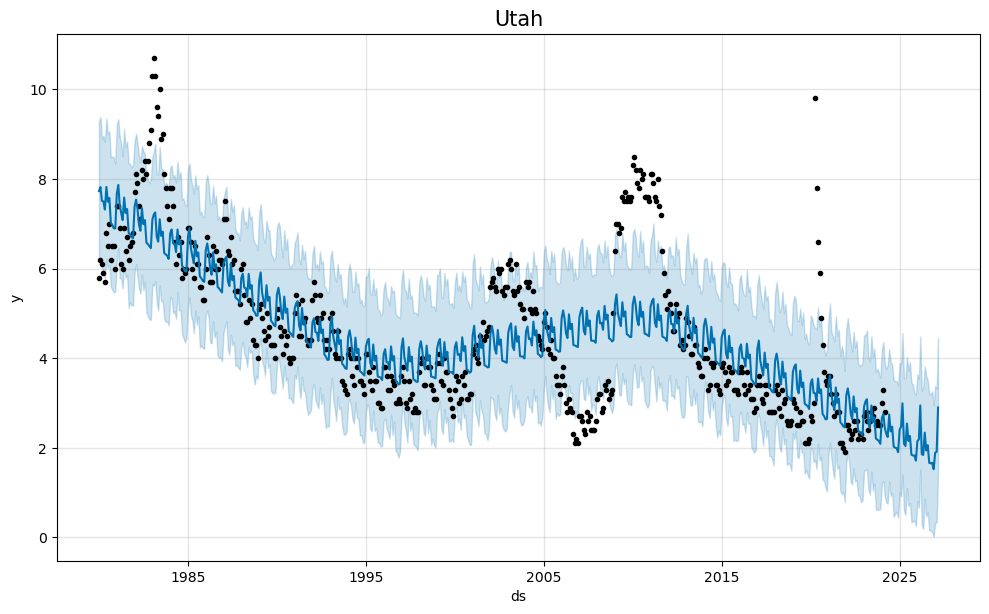

In [58]:
# Forecast unemployment for the states with the highest unemployment
# Loop through the states
for state in lowest_unemployment.index:
    m, forecast = predict(pd.DataFrame(unemployment_states_df.loc[:,state]), period)
    forecast_plot(m, forecast, state)

### Further analysis on the two anomaly states - NV and CA

#### Pandemic unemployment recovery analysis

In [59]:
# Filter the data from the start to the end of the pandemic
pandemic_df = unemployment_states_df.loc['2020-Jan'].T.join(unemployment_states_df.loc['2023-May'].T)
# Add additional column to show recovery
pandemic_df['Recovery'] =  pandemic_df.iloc[:,1] - pandemic_df.iloc[:,0]
# Sort the values
pandemic_df.sort_values(by='Recovery', inplace=True)
# Show the tail of the dataframe
pandemic_df.tail()

Date  2020-01-01 00:00:00  2023-05-01 00:00:00  Recovery
NJ                    4.3                  4.3       0.0
IL                    4.0                  4.0       0.0
TX                    3.7                  3.9       0.2
HI                    2.3                  2.7       0.4
NV                    4.5                  5.0       0.5

In [60]:
# Create a plot to show the change in unemployment before and after the pandemic

fig = px.bar(pandemic_df['Recovery'],
       labels={'value': '% Change', 'index': 'State', 'color': 'Change'},
             color=pandemic_df['Recovery'],
             title='<b>Pandemic change in unemployment rate (Jan-20 to May-23)</b>')
fig.update_xaxes(tickangle=-90)
fig.update_xaxes({"dtick": 1})
fig.update_layout(title_x=0.5)
fig.show()

In [61]:
# Save image to file
fig.write_image('images/pandemic.png')

### Conclusion and Recommendations

#### All three analysis indicate a drop in unemployment, if the Federal reserve were to cut the Fed Funds rate based on inflation moving towards its target range.

#### 1. Unemployment and PCE Inflation rate have a low-moderate correlation depending on the state. There is a stronger correlation between lagged (24 months) unemployment and PCE inflation. This implies unemployment will fall if PCE inflation rate continues to drop.

#### 2. Unemployment and Fed funds rate have a low-moderate correlation depending on the state. There is a stronger correlation between the lagged unemployment (36 months) and Fed Funds rate. This would imply unemployment will continue to fall if the Fed starts to reduce the Fed Funds rate.

#### 3. The Prophet forecast model shows a downward trend in unemployment rates for all states.

#### Additional analysis were carried out after reviewing the results of the three analysis, as there were two anomalies (CA and NV) in the results. The anomalies showed unemployment had no correlation with PCE inflation rate or Feds Funds rate. 

#### 4. Pandemic Analysis - This showed that NV was the worst affected state and had still not recovered completely from the pandemic.